In [12]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
import sys
sys.path.append('..')
%pylab inline

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert cylindrical to rectangular
R, phi, z = rect_to_cyl(samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vR, vT, vz = rect_to_cyl_vec(samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5], samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
samples_qdf = np.stack((R, phi, z, vR, vT, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (R)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (phi)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vR)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vT)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))

Populating the interactive namespace from numpy and matplotlib
#stars 1699708
min/max/mean (R) 7.80091199779 8.79962027735 8.29194098976
min/max/mean (phi) 3.08134693839 3.20183526017 3.14130030289
min/max/mean (z) -0.472240992289 0.525186432321 0.0205541620714
min/max/mean (vR) -226.541732449 236.497052579 0.00739381590152
min/max/mean (vT) 18.0377131063 300.644001151 200.9257125
min/max/mean (vz) -78.6318475051 79.4952977672 -0.00151810605736


In [2]:
#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-06-25 - Updated - Ayush Pandhi
    """
    #Scaling velocities with standard deviation
    inputs_std = np.nanstd(inputs, axis=0)
    inputs = inputs/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    IQR = iqr(inputs)
    A = min(np.std(inputs), IQR/1.34)
    bw = 1.059 * A * N ** (-1/5.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-06-25 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = samples/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_qdf_epanechnikov = generate_KDE(samples_qdf, 'epanechnikov')

In [4]:
#Creating sample points for each parameter changing
N = 100

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(samples_qdf[:,0])
mean_phi = np.ones((N, 1))*np.mean(samples_qdf[:,1])
mean_z = np.ones((N, 1))*np.mean(samples_qdf[:,2])
mean_vR = np.ones((N, 1))*np.mean(samples_qdf[:,3])
mean_vT = np.ones((N, 1))*np.mean(samples_qdf[:,4])
mean_vz = np.ones((N, 1))*np.mean(samples_qdf[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(samples_qdf[:,0]), max(samples_qdf[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(samples_qdf[:,1]), max(samples_qdf[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(samples_qdf[:,2]), max(samples_qdf[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(samples_qdf[:,3]), max(samples_qdf[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(samples_qdf[:,4]), max(samples_qdf[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(samples_qdf[:,5]), max(samples_qdf[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

Variable R at Scotts bw


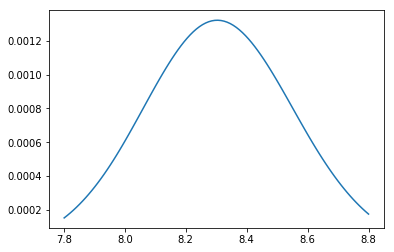

In [14]:
#Variable R plot
print('Variable R at Scotts bw')

Rplot_epanechnikov = kde_qdf_epanechnikov(sample_R)
plt.plot(R_points, Rplot_epanechnikov)

Variable phi at Scotts bw


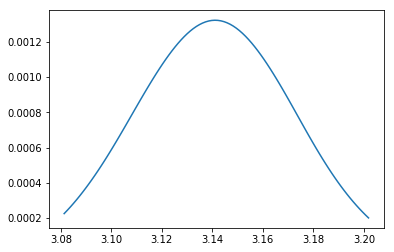

In [15]:
#Variable phi plot
print('Variable phi at Scotts bw')

phiplot_epanechnikov = kde_qdf_epanechnikov(sample_phi)
plt.plot(phi_points, phiplot_epanechnikov)

Variable z at Scotts bw


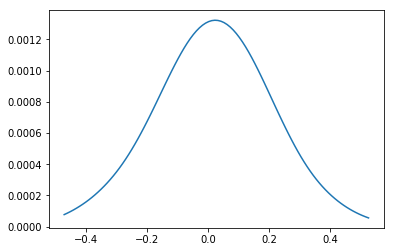

In [16]:
#Variable z plot
print('Variable z at Scotts bw')

zplot_epanechnikov = kde_qdf_epanechnikov(sample_z)
plt.plot(z_points, zplot_epanechnikov)

Variable vR at Scotts bw


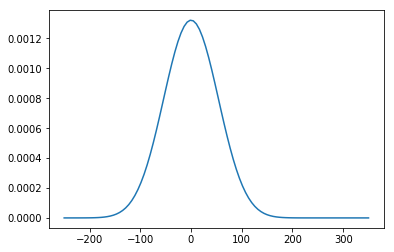

In [17]:
#Variable vR plot
print('Variable vR at Scotts bw')

vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov)

Variable vT at Scotts bw


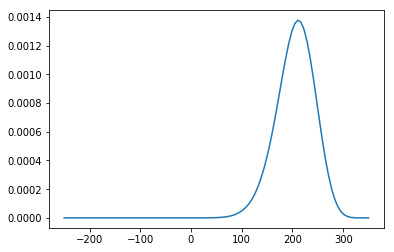

In [18]:
#Variable vT plot
print('Variable vT at Scotts bw')

vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov)

Variable vz at Scotts bw


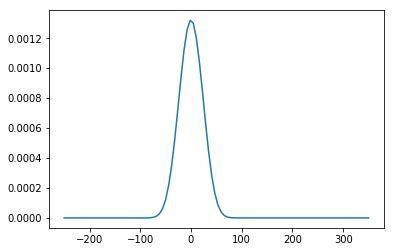

In [19]:
#Variable vz plot
print('Variable vz at Scotts bw')

vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov)

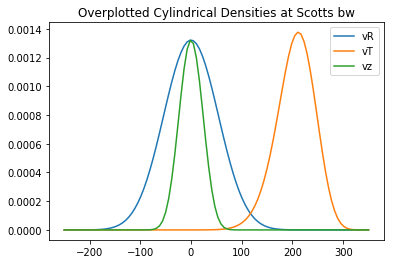

In [13]:
#For variable vR
vR_points = np.linspace(-250, 350, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-250, 350, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-250, 350, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov, label='vR')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov, label='vT')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov, label='vz')

#Show plot
plt.title('Overplotted Cylindrical Densities at Scotts bw')
plt.legend()
plt.show()

INTEGRATED

In [37]:
from scipy.integrate import dblquad
import time

#input values for velocities (vR, vT, vz)
v_input = np.linspace(-200, 400, 100)

# 2x SCOTTS RULE OF THUMB 
# -----------------
# Integrate over vR
# -----------------

def kde_qdf_cyl_vR(vT, vz, R, phi, z, vR):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vR(kde_qdf_epanechnikov, vR): #bounds of vT = [0, 300], bounds of vz = [-100, 100]
    print ("Evaluating at vR =", vR)
    return dblquad(kde_qdf_cyl_vR, 0, 300, -100, 100, args=([8.3, 3.14, 0., vR]), epsabs=0.001)  # args=(R, phi, z, vR)

vR_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vT from [0, 300] and vz from [-100, 100].")
print("KDE Evaluations along vR from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vR_output[counter - 1], error = integrate_over_vR(kde_qdf_epanechnikov, v)
    print("Value:", vR_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vT
# -----------------

def kde_qdf_cyl_vT(vR, vz, R, phi, z, vT):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vT(kde_qdf_epanechnikov, vT): #bounds of vR = [-100, 100], bounds of vz = [-100, 100]
    print ("Evaluating at vT =", vT)
    return dblquad(kde_qdf_cyl_vT, -100, 100, -100, 100, args=([8.3, 3.14, 0., vT]), epsabs=0.01)  # args=(R, phi, z, vR)

vT_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vz from [-100, 100].")
print("KDE Evaluations along vT from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vT_output[counter - 1], error = integrate_over_vT(kde_qdf_epanechnikov, v)
    print("Value:", vT_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()
    
# -----------------
# Integrate over vz
# -----------------

def kde_qdf_cyl_vz(vR, vT, R, phi, z, vz):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_vz(kde_qdf_epanechnikov, vz): #bounds of vR = [-100, 100], bounds of vT = [0, 300]
    print ("Evaluating at vz =", vz)
    return dblquad(kde_qdf_cyl_vz, -100, 100, 0, 300, args=([8.3, 3.14, 0., vz]), epsabs=0.001)  # args=(R, phi, z, vR)

vz_output = np.ones([100])


print("With R, phi, z = 8.3, 3.14, 0., integrating over vR from [-100, 100] and vT from [0, 300].")
print("KDE Evaluations along vz from [-200, 400] over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for v in np.nditer(v_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    vz_output[counter - 1], error = integrate_over_vz(kde_qdf_epanechnikov, v)
    print("Value:", vz_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()




With R, phi, z = 8.3, 3.14, 0., integrating over vT from [0, 300] and vz from [-100, 100].
KDE Evaluations along vR from [-200, 400] over 100 subintervals.

Evaluation: 1
Evaluating at vR = -200.0
Value: 0.000125554324619
Time to integrate: 1.63s
Time elapsed: 0.03 min

Evaluation: 2
Evaluating at vR = -193.93939393939394
Value: 0.000178577170763
Time to integrate: 1.4s
Time elapsed: 0.05 min

Evaluation: 3
Evaluating at vR = -187.87878787878788
Value: 0.000251325383572
Time to integrate: 0.52s
Time elapsed: 0.06 min

Evaluation: 4
Evaluating at vR = -181.8181818181818
Value: 0.000350182684768
Time to integrate: 0.49s
Time elapsed: 0.07 min

Evaluation: 5
Evaluating at vR = -175.75757575757575
Value: 0.000481262162317
Time to integrate: 0.48s
Time elapsed: 0.08 min

Evaluation: 6
Evaluating at vR = -169.6969696969697
Value: 0.000650222954746
Time to integrate: 0.48s
Time elapsed: 0.08 min

Evaluation: 7
Evaluating at vR = -163.63636363636363
Value: 0.000866143409432
Time to integrate: 

Value: 0.000184078375894
Time to integrate: 0.51s
Time elapsed: 1.26 min

Evaluation: 66
Evaluating at vR = 193.93939393939394
Value: 0.000129276060826
Time to integrate: 0.48s
Time elapsed: 1.27 min

Evaluation: 67
Evaluating at vR = 200.0
Value: 9.18225598969e-05
Time to integrate: 1.65s
Time elapsed: 1.29 min

Evaluation: 68
Evaluating at vR = 206.06060606060606
Value: 6.47341963964e-05
Time to integrate: 1.64s
Time elapsed: 1.32 min

Evaluation: 69
Evaluating at vR = 212.12121212121212
Value: 4.31594922941e-05
Time to integrate: 1.77s
Time elapsed: 1.35 min

Evaluation: 70
Evaluating at vR = 218.1818181818182
Value: 2.75194240019e-05
Time to integrate: 1.96s
Time elapsed: 1.38 min

Evaluation: 71
Evaluating at vR = 224.24242424242425
Value: 1.73272107821e-05
Time to integrate: 1.57s
Time elapsed: 1.41 min

Evaluation: 72
Evaluating at vR = 230.3030303030303
Value: 1.01593818689e-05
Time to integrate: 1.73s
Time elapsed: 1.44 min

Evaluation: 73
Evaluating at vR = 236.36363636363637

Value: 0.000241807381146
Time to integrate: 5.09s
Time elapsed: 0.49 min

Evaluation: 36
Evaluating at vT = 12.121212121212125
Value: 0.000530893240515
Time to integrate: 5.61s
Time elapsed: 0.59 min

Evaluation: 37
Evaluating at vT = 18.181818181818187
Value: 0.00103752952043
Time to integrate: 5.05s
Time elapsed: 0.67 min

Evaluation: 38
Evaluating at vT = 24.24242424242425
Value: 0.00191240066375
Time to integrate: 5.45s
Time elapsed: 0.76 min

Evaluation: 39
Evaluating at vT = 30.30303030303031
Value: 0.00337437601876
Time to integrate: 1.46s
Time elapsed: 0.79 min

Evaluation: 40
Evaluating at vT = 36.363636363636374
Value: 0.00575041609485
Time to integrate: 4.85s
Time elapsed: 0.87 min

Evaluation: 41
Evaluating at vT = 42.424242424242436
Value: 0.00958372992496
Time to integrate: 5.44s
Time elapsed: 0.96 min

Evaluation: 42
Evaluating at vT = 48.48484848484847
Value: 0.0155461134639
Time to integrate: 5.17s
Time elapsed: 1.04 min

Evaluation: 43
Evaluating at vT = 54.5454545454

Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.0 min

Evaluation: 2
Evaluating at vz = -193.93939393939394
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.01 min

Evaluation: 3
Evaluating at vz = -187.87878787878788
Value: 0.0
Time to integrate: 0.23s
Time elapsed: 0.01 min

Evaluation: 4
Evaluating at vz = -181.8181818181818
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.02 min

Evaluation: 5
Evaluating at vz = -175.75757575757575
Value: 0.0
Time to integrate: 0.23s
Time elapsed: 0.02 min

Evaluation: 6
Evaluating at vz = -169.6969696969697
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.02 min

Evaluation: 7
Evaluating at vz = -163.63636363636363
Value: 0.0
Time to integrate: 0.23s
Time elapsed: 0.03 min

Evaluation: 8
Evaluating at vz = -157.57575757575756
Value: 0.0
Time to integrate: 0.23s
Time elapsed: 0.03 min

Evaluation: 9
Evaluating at vz = -151.5151515151515
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.04 min

Evaluation: 10
Evaluating at vz = -145.4

Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.86 min

Evaluation: 71
Evaluating at vz = 224.24242424242425
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.87 min

Evaluation: 72
Evaluating at vz = 230.3030303030303
Value: 0.0
Time to integrate: 0.23s
Time elapsed: 0.87 min

Evaluation: 73
Evaluating at vz = 236.36363636363637
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.87 min

Evaluation: 74
Evaluating at vz = 242.42424242424244
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.88 min

Evaluation: 75
Evaluating at vz = 248.4848484848485
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.88 min

Evaluation: 76
Evaluating at vz = 254.54545454545456
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.89 min

Evaluation: 77
Evaluating at vz = 260.6060606060606
Value: 0.0
Time to integrate: 0.24s
Time elapsed: 0.89 min

Evaluation: 78
Evaluating at vz = 266.6666666666667
Value: 0.0
Time to integrate: 0.23s
Time elapsed: 0.89 min

Evaluation: 79
Evaluating at vz = 272.72

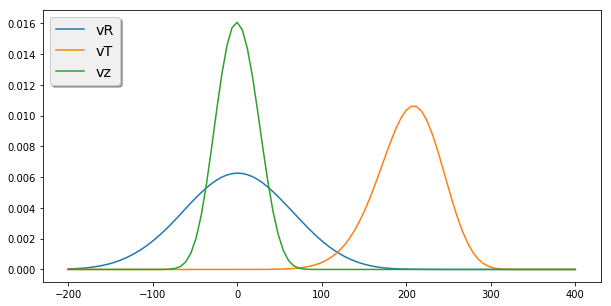

In [38]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(v_input, vR_output/np.sum(vR_output)/(v_input[1]-v_input[0]), label='vR') #normalized area to 1
ax.plot(v_input, vT_output/np.sum(vT_output)/(v_input[1]-v_input[0]), label='vT')
ax.plot(v_input, vz_output/np.sum(vz_output)/(v_input[1]-v_input[0]), label='vz')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')